# BERT SHAP

In [102]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shap
from scipy.stats import spearmanr

In [2]:
project_root_dir = os.path.relpath(os.path.join('..', '..'), os.curdir)
if project_root_dir not in sys.path:
    sys.path += [project_root_dir]

In [3]:
from src.data.dataload import \
    load_sst, \
    load_agnews
from src.data.perturbations import \
    remove_commas, \
    remove_all_punctuation, \
    switch_gender, \
    strip_trailing_punct, \
    add_typo, \
    change_first_name, \
    change_last_name, \
    change_location, \
    contraction, \
    swap_adjectives, \
    add_perturbations
from src.models.bertmodel import BertModel
from src.explainers.explainers import SHAPExplainer

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load datasets

In [5]:
sst = load_sst()
agnews = load_agnews()

input_data = {
    'sst': sst, 
    'agnews': agnews
}

train = {}
dev = {}
test = {}

for dataset in input_data.keys():
    train[dataset], dev[dataset], test[dataset] = input_data[dataset].train_val_test

Using custom data configuration default
Reusing dataset ag_news (/Users/stevengeorge/.cache/huggingface/datasets/ag_news/default/0.0.0/17ec33e23df9e89565131f989e0fdf78b0cc4672337b582da83fc3c9f79fe34d)


In [6]:
train['sst'].head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


In [7]:
print(train['sst'].shape, dev['sst'].shape, test['sst'].shape)

(8544, 2) (1101, 2) (2210, 2)


In [8]:
train['agnews'].head()

,sentence,label,title
0,"Reuters - Short-sellers, Wall Street's dwindli...",2,Wall St. Bears Claw Back Into the Black (Reuters)
1,Reuters - Private investment firm Carlyle Grou...,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Reuters - Soaring crude prices plus worriesabo...,2,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Reuters - Authorities have halted oil exportfl...,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,"AFP - Tearaway world oil prices, toppling reco...",2,"Oil prices soar to all-time record, posing new..."


In [9]:
print(train['agnews'].shape, dev['agnews'].shape, test['agnews'].shape)

(108000, 3) (12000, 3) (7600, 3)


## Load models

SST

In [10]:
bert_sst = BertModel(device=device)
bert_sst.load_model(sst)

In [11]:
print(f'Individual prediction for {sst.NAME}')
bert_sst.predict(test['sst'].sentence[0])

Individual prediction for sst


,logits,class_probabilities,label
0,-0.986764,0.040054,2
1,1.235412,0.369594,2
2,1.532938,0.497667,2
3,-0.238388,0.084657,2
4,-2.594064,0.008028,2


In [12]:
print(f'Batch prediction for {sst.NAME}')
bert_sst.predict_batch_df(test['sst'].head(100), input_col=sst.SENTENCE)

Batch prediction for sst


,logits,class_probabilities,label
0,"[-0.9867638349533081, 1.2354124784469604, 1.53...","[0.04005404934287071, 0.3695943355560303, 0.49...",2
1,"[-1.754173994064331, -0.8248215913772583, 0.37...","[0.027608154341578484, 0.06992782652378082, 0....",3
2,"[-2.8735032081604004, -1.9821763038635254, -0....","[0.002674192888662219, 0.006520653143525124, 0...",3
3,"[-2.725583553314209, -1.7797045707702637, 0.18...","[0.0050294422544538975, 0.012951195240020752, ...",3
4,"[-2.492720365524292, -2.2499923706054688, -0.6...","[0.0027276265900582075, 0.0034769659396260977,...",4
...,...,...,...
95,"[-2.124051332473755, -0.6128084659576416, 0.46...","[0.01905813254415989, 0.0863783210515976, 0.25...",3
96,"[-0.28996801376342773, 1.4170405864715576, 1.3...","[0.07925046980381012, 0.4368639886379242, 0.42...",1
97,"[-2.7277023792266846, -2.30313777923584, -0.24...","[0.0025906008668243885, 0.003960833884775639, ...",3
98,"[-2.707550525665283, -1.587195634841919, 0.298...","[0.00464598136022687, 0.01424431148916483, 0.0...",3


AG News

In [13]:
bert_agnews = BertModel(device=device)
bert_agnews.load_model(agnews)

In [14]:
print(f'Individual prediction for {agnews.NAME}')
bert_agnews.predict(test['agnews'].sentence[0])

Individual prediction for agnews


,logits,class_probabilities,label
0,0.042553,0.022081,2
1,-3.648040,0.000551,2
2,3.826154,0.971000,2
3,-1.200886,0.006368,2


In [15]:
print(f'Batch prediction for {agnews.NAME}')
bert_agnews.predict_batch_df(test['agnews'].head(10), input_col=agnews.SENTENCE)

Batch prediction for agnews


,logits,class_probabilities,label
0,"[0.04255253076553345, -3.6480393409729004, 3.8...","[0.022081149742007256, 0.0005510844057425857, ...",2
1,"[-0.7225905060768127, -2.5803427696228027, -2....","[0.001619855291210115, 0.00025273457868024707,...",3
2,"[-0.43245795369148254, -2.9780147075653076, -1...","[0.004643819760531187, 0.00036421179538592696,...",3
3,"[0.26466619968414307, 3.3352887630462646, -3.2...","[0.04081227630376816, 0.879721462726593, 0.001...",1
4,"[0.41556620597839355, -2.320911407470703, -2.1...","[0.022335022687911987, 0.001447268994525075, 0...",3
5,"[-2.8811357021331787, -2.5347037315368652, -0....","[0.0001745583285810426, 0.00024682775256223977...",3
6,"[-2.3804450035095215, -2.653226613998413, -1.4...","[0.00021428102627396584, 0.0001631234044907614...",3
7,"[-2.693422317504883, -2.167076587677002, -1.53...","[0.00015939476725179702, 0.0002698130265343934...",3
8,"[-0.12801218032836914, -3.1953518390655518, -1...","[0.011645975522696972, 0.0005420598899945617, ...",3
9,"[-0.3894408941268921, -4.089913845062256, 0.83...","[0.022109737619757652, 0.0005463722627609968, ...",3


In [16]:
test['agnews'].sentence[0]

"Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."

In [17]:
bert_agnews.predict_proba(test['agnews'].sentence[0])

0    0.022081
1    0.000551
2    0.971000
3    0.006368
Name: class_probabilities, dtype: float64

## SHAP for SST

In [18]:
dev['sst'].head()

,sentence,label
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4


In [19]:
np.random.seed(3)
dev_sst_subset = dev['sst'].copy().sample(n=20)
dev_sst_subset.reset_index(drop=True, inplace=True)
dev_sst_subset.head()

,sentence,label
0,Chabrol has taken promising material for a bla...,1
1,"To my taste , the film 's comic characters com...",2
2,"A difficult , absorbing film that manages to c...",3
3,A strangely compelling and brilliantly acted p...,4
4,This is so bad .,0


In [21]:
PERTURBATION_REDUCTION = ['strip_punct', 'remove_commas', 'remove_all_punct']
PERTURBATION_LIST = PERTURBATION_REDUCTION + [
    'contraction','change_first_name','change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'
]

PERT_STRING_TO_FUNCTION = {
    'strip_punct': strip_trailing_punct, 
    'remove_commas': remove_commas, 
    'remove_all_punct': remove_all_punctuation, 
    'contraction': contraction,
    'change_first_name': change_first_name,
    'change_last_name': change_last_name, 
    'change_location': change_location, 
    'add_typo': add_typo, 
    'switch_gender': switch_gender, 
    'swap_adj': swap_adjectives
}

In [99]:
def bert_detokenize(token_list):
    """
    Reverse BERT tokenization accounting for ##s representing subwords. Based on https://github.com/huggingface/transformers/issues/36
    """
    text = ' '.join(token_list)
    text = text.replace(' ##', '')
    text = text.replace("` `", "``")
    text = text.replace("' '", "''")
    return text

In [23]:
shap_explainer = SHAPExplainer(bert_sst)

In [23]:
perturbation = 'remove_commas'

In [25]:
%%time
perturbation_df = add_perturbations(
    df=dev_sst_subset,
    tokenizer=bert_sst.tokenizer,
    sentence_col_name=sst.SENTENCE, 
    perturbation_functions=[
        PERT_STRING_TO_FUNCTION[perturbation]
    ]
)

CPU times: user 54.5 ms, sys: 2.07 ms, total: 56.5 ms
Wall time: 55.2 ms


In [26]:
print(perturbation_df.shape)
perturbation_df.head()

(100, 7)


,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind
0,Chabrol has taken promising material for a bla...,1,"[cha, ##bro, ##l, has, taken, promising, mater...",Chabrol has taken promising material for a bla...,"[cha, ##bro, ##l, has, taken, promising, mater...",0,None
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3]
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2]
3,A strangely compelling and brilliantly acted p...,4,"[a, strangely, compelling, and, brilliant, ##l...",A strangely compelling and brilliantly acted p...,"[a, strangely, compelling, and, brilliant, ##l...",0,None
4,This is so bad .,0,"[this, is, so, bad, .]",This is so bad .,"[this, is, so, bad, .]",0,None


In [29]:
# Drop unsuccessful perturbations
perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_success'] == 1]
print(perturbation_df.shape)

(59, 7)


In [34]:
# Overwrite '_concat' column with corrected reversal of tokenization
perturbation_df[f'{perturbation}_concat'] = perturbation_df[f'{perturbation}_tokens'].apply(bert_detokenize)

In [37]:
# Original prediction
perturbation_df['orig_prediction'] = bert_sst.predict_label_batch(perturbation_df['sentence'])

In [38]:
# Prediction on new sentence
perturbation_df[f'{perturbation}_prediction'] = bert_sst.predict_label_batch(perturbation_df[f'{perturbation}_concat'])

In [42]:
# Drop examples where predictions which are not the same
perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_prediction'] == perturbation_df['orig_prediction']]
print(perturbation_df.shape)

(57, 9)


In [46]:
# Flag for correct prediction
perturbation_df['correct_prediction'] = np.where(
    perturbation_df['label'] == perturbation_df['orig_prediction'],
    1,
    0
)
print(perturbation_df['correct_prediction'].sum())

23


In [48]:
perturbation_df.head()

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,orig_prediction,remove_commas_prediction,correct_prediction
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3],2,2,1
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2],3,3,1
5,It will grip even viewers who are n't interest...,3,"[it, will, grip, even, viewers, who, are, n, '...",it will grip even viewers who are n ' t intere...,"[it, will, grip, even, viewers, who, are, n, '...",1,[13],3,3,1
6,"The X potion gives the quickly named Blossom ,...",1,"[the, x, potion, gives, the, quickly, named, b...",the x potion gives the quickly named blossom ...,"[the, x, potion, gives, the, quickly, named, b...",1,"[8, 24]",3,3,0
10,Schaeffer has to find some hook on which to ha...,1,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",schaeffer has to find some hook on which to ha...,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",1,[17],1,1,1


In [49]:
# SHAP values for original sentence
shap_values = shap_explainer.explain_instances(perturbation_df['sentence'])

Partition explainer:   4%|▎         | 2/57 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 4/57 [00:20<02:52,  3.26s/it]

Partition explainer:   9%|▉         | 5/57 [00:27<03:40,  4.25s/it]

Partition explainer:  11%|█         | 6/57 [00:33<04:11,  4.93s/it]

Partition explainer:  12%|█▏        | 7/57 [00:40<04:31,  5.42s/it]

Partition explainer:  14%|█▍        | 8/57 [00:46<04:42,  5.77s/it]

Partition explainer:  16%|█▌        | 9/57 [00:53<04:48,  6.01s/it]

Partition explainer:  18%|█▊        | 10/57 [01:00<04:50,  6.18s/it]

Partition explainer:  19%|█▉        | 11/57 [01:06<04:49,  6.30s/it]

Partition explainer:  21%|██        | 12/57 [01:13<04:47,  6.39s/it]

Partition explainer:  23%|██▎       | 13/57 [01:19<04:43,  6.45s/it]

Partition explainer:  25%|██▍       | 14/57 [01:26<04:38,  6.48s/it]

Partition explainer:  26%|██▋       | 15/57 [01:32<04:33,  6.51s/it]

Partition explainer:  28%|██▊       | 16/57 [01:39<04:27,  6.52s/it]

Partition explainer:  30%|██▉       | 17/57 [01:46<04:21,  6.53s/it]

Partition explainer:  32%|███▏      | 18/57 [01:52<04:14,  6.53s/it]

Partition explainer:  33%|███▎      | 19/57 [01:59<04:08,  6.53s/it]

Partition explainer:  35%|███▌      | 20/57 [02:05<04:01,  6.53s/it]

Partition explainer:  37%|███▋      | 21/57 [02:12<03:55,  6.53s/it]

Partition explainer:  39%|███▊      | 22/57 [02:18<03:48,  6.53s/it]

Partition explainer:  40%|████      | 23/57 [02:25<03:41,  6.52s/it]

Partition explainer:  42%|████▏     | 24/57 [02:31<03:35,  6.52s/it]

Partition explainer:  44%|████▍     | 25/57 [02:38<03:28,  6.51s/it]

Partition explainer:  46%|████▌     | 26/57 [02:44<03:22,  6.52s/it]

Partition explainer:  47%|████▋     | 27/57 [02:51<03:15,  6.52s/it]

Partition explainer:  49%|████▉     | 28/57 [02:57<03:08,  6.52s/it]

Partition explainer:  51%|█████     | 29/57 [03:04<03:02,  6.52s/it]

Partition explainer:  53%|█████▎    | 30/57 [03:10<02:56,  6.53s/it]

Partition explainer:  54%|█████▍    | 31/57 [03:17<02:49,  6.53s/it]

Partition explainer:  56%|█████▌    | 32/57 [03:23<02:43,  6.52s/it]

Partition explainer:  58%|█████▊    | 33/57 [03:30<02:36,  6.52s/it]

Partition explainer:  60%|█████▉    | 34/57 [03:36<02:29,  6.52s/it]

Partition explainer:  61%|██████▏   | 35/57 [03:43<02:23,  6.52s/it]

Partition explainer:  63%|██████▎   | 36/57 [03:49<02:17,  6.53s/it]

Partition explainer:  65%|██████▍   | 37/57 [03:56<02:10,  6.54s/it]

Partition explainer:  67%|██████▋   | 38/57 [04:03<02:04,  6.54s/it]

Partition explainer:  68%|██████▊   | 39/57 [04:09<01:57,  6.54s/it]

Partition explainer:  70%|███████   | 40/57 [04:16<01:51,  6.54s/it]

Partition explainer:  72%|███████▏  | 41/57 [04:22<01:44,  6.54s/it]

Partition explainer:  74%|███████▎  | 42/57 [04:29<01:38,  6.54s/it]

Partition explainer:  75%|███████▌  | 43/57 [04:35<01:31,  6.54s/it]

Partition explainer:  77%|███████▋  | 44/57 [04:42<01:24,  6.53s/it]

Partition explainer:  79%|███████▉  | 45/57 [04:48<01:18,  6.57s/it]

Partition explainer:  81%|████████  | 46/57 [04:55<01:12,  6.55s/it]

Partition explainer:  82%|████████▏ | 47/57 [05:01<01:05,  6.54s/it]

Partition explainer:  84%|████████▍ | 48/57 [05:08<00:58,  6.54s/it]

Partition explainer:  86%|████████▌ | 49/57 [05:15<00:52,  6.53s/it]

Partition explainer:  88%|████████▊ | 50/57 [05:21<00:45,  6.53s/it]

Partition explainer:  89%|████████▉ | 51/57 [05:28<00:39,  6.52s/it]

Partition explainer:  91%|█████████ | 52/57 [05:34<00:32,  6.52s/it]

Partition explainer:  93%|█████████▎| 53/57 [05:41<00:26,  6.52s/it]

Partition explainer:  95%|█████████▍| 54/57 [05:48<00:20,  6.76s/it]

Partition explainer:  96%|█████████▋| 55/57 [05:55<00:13,  6.92s/it]

Partition explainer:  98%|█████████▊| 56/57 [06:02<00:06,  6.88s/it]

Partition explainer: 100%|██████████| 57/57 [06:09<00:00,  6.93s/it]

Partition explainer: 58it [06:16,  6.72s/it]                        


In [80]:
perturbation_df['shap_orig_tokens'] = shap_values.data
perturbation_df['shap_orig_tokens'] = perturbation_df['shap_orig_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens

In [81]:
perturbation_df.head()

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,orig_prediction,remove_commas_prediction,correct_prediction,shap_orig_tokens
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3],2,2,1,"[to , my , taste , , , the , film , ' , s , co..."
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2],3,3,1,"[a , difficult , , , absorbing , film , that ,..."
5,It will grip even viewers who are n't interest...,3,"[it, will, grip, even, viewers, who, are, n, '...",it will grip even viewers who are n ' t intere...,"[it, will, grip, even, viewers, who, are, n, '...",1,[13],3,3,1,"[it , will , grip , even , viewers , who , are..."
6,"The X potion gives the quickly named Blossom ,...",1,"[the, x, potion, gives, the, quickly, named, b...",the x potion gives the quickly named blossom ...,"[the, x, potion, gives, the, quickly, named, b...",1,"[8, 24]",3,3,0,"[the , x , potion , gives , the , quickly , na..."
10,Schaeffer has to find some hook on which to ha...,1,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",schaeffer has to find some hook on which to ha...,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",1,[17],1,1,1,"[sc , ##hae , ##ffer , has , to , find , some ..."


In [119]:
perturbation_df['shap_orig_values'] = shap_values.values
perturbation_df['shap_orig_values'] = perturbation_df['shap_orig_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

# Only keep SHAP values for label predicted
perturbation_df['shap_orig_values'] = perturbation_df.apply(lambda x: x['shap_orig_values'][:, x['orig_prediction']], axis=1)

In [120]:
perturbation_df.head()

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,orig_prediction,remove_commas_prediction,correct_prediction,shap_orig_tokens,shap_orig_values
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3],2,2,1,"[to , my , taste , , , the , film , ' , s , co...","[-0.012986115102345744, -0.012986115102345744,..."
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2],3,3,1,"[a , difficult , , , absorbing , film , that ,...","[0.011156889920433363, 0.011156889920433363, 0..."
5,It will grip even viewers who are n't interest...,3,"[it, will, grip, even, viewers, who, are, n, '...",it will grip even viewers who are n ' t intere...,"[it, will, grip, even, viewers, who, are, n, '...",1,[13],3,3,1,"[it , will , grip , even , viewers , who , are...","[0.007894540045942578, 0.007894540045942578, 0..."
6,"The X potion gives the quickly named Blossom ,...",1,"[the, x, potion, gives, the, quickly, named, b...",the x potion gives the quickly named blossom ...,"[the, x, potion, gives, the, quickly, named, b...",1,"[8, 24]",3,3,0,"[the , x , potion , gives , the , quickly , na...","[0.005473468225035402, 0.005473468225035402, 0..."
10,Schaeffer has to find some hook on which to ha...,1,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",schaeffer has to find some hook on which to ha...,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",1,[17],1,1,1,"[sc , ##hae , ##ffer , has , to , find , some ...","[0.018988311962018927, 0.018988311962018927, 0..."


In [124]:
# Length of SHAP tokens same as lengtth of SHAP values
assert perturbation_df.shape[0] == (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df['shap_orig_values'].apply(len)).sum()

In [125]:
# SHAP values for perturbed sentence
shap_values = shap_explainer.explain_instances(perturbation_df[f'{perturbation}_concat'])

Partition explainer:   4%|▎         | 2/57 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 4/57 [00:20<02:58,  3.37s/it]

Partition explainer:   9%|▉         | 5/57 [00:27<03:48,  4.40s/it]

Partition explainer:  11%|█         | 6/57 [00:33<04:20,  5.10s/it]

Partition explainer:  12%|█▏        | 7/57 [00:40<04:38,  5.56s/it]

Partition explainer:  14%|█▍        | 8/57 [00:47<04:51,  5.94s/it]

Partition explainer:  16%|█▌        | 9/57 [00:54<04:58,  6.23s/it]

Partition explainer:  18%|█▊        | 10/57 [01:01<05:02,  6.43s/it]

Partition explainer:  19%|█▉        | 11/57 [01:07<05:01,  6.56s/it]

Partition explainer:  21%|██        | 12/57 [01:14<04:59,  6.64s/it]

Partition explainer:  23%|██▎       | 13/57 [01:21<04:54,  6.69s/it]

Partition explainer:  25%|██▍       | 14/57 [01:28<04:48,  6.71s/it]

Partition explainer:  26%|██▋       | 15/57 [01:35<04:42,  6.71s/it]

Partition explainer:  28%|██▊       | 16/57 [01:41<04:34,  6.70s/it]

Partition explainer:  30%|██▉       | 17/57 [01:48<04:26,  6.66s/it]

Partition explainer:  32%|███▏      | 18/57 [01:54<04:19,  6.65s/it]

Partition explainer:  33%|███▎      | 19/57 [02:01<04:14,  6.71s/it]

Partition explainer:  35%|███▌      | 20/57 [02:08<04:09,  6.75s/it]

Partition explainer:  37%|███▋      | 21/57 [02:15<04:04,  6.80s/it]

Partition explainer:  39%|███▊      | 22/57 [02:22<03:56,  6.75s/it]

Partition explainer:  40%|████      | 23/57 [02:28<03:47,  6.69s/it]

Partition explainer:  42%|████▏     | 24/57 [02:35<03:45,  6.82s/it]

Partition explainer:  44%|████▍     | 25/57 [02:42<03:39,  6.87s/it]

Partition explainer:  46%|████▌     | 26/57 [02:49<03:35,  6.94s/it]

Partition explainer:  47%|████▋     | 27/57 [02:56<03:29,  6.97s/it]

Partition explainer:  49%|████▉     | 28/57 [03:03<03:21,  6.94s/it]

Partition explainer:  51%|█████     | 29/57 [03:10<03:13,  6.91s/it]

Partition explainer:  53%|█████▎    | 30/57 [03:17<03:05,  6.89s/it]

Partition explainer:  54%|█████▍    | 31/57 [03:24<02:58,  6.88s/it]

Partition explainer:  56%|█████▌    | 32/57 [03:31<02:51,  6.87s/it]

Partition explainer:  58%|█████▊    | 33/57 [03:38<02:44,  6.87s/it]

Partition explainer:  60%|█████▉    | 34/57 [03:44<02:37,  6.86s/it]

Partition explainer:  61%|██████▏   | 35/57 [03:51<02:30,  6.86s/it]

Partition explainer:  63%|██████▎   | 36/57 [03:58<02:23,  6.85s/it]

Partition explainer:  65%|██████▍   | 37/57 [04:05<02:17,  6.85s/it]

Partition explainer:  67%|██████▋   | 38/57 [04:12<02:10,  6.85s/it]

Partition explainer:  68%|██████▊   | 39/57 [04:19<02:03,  6.84s/it]

Partition explainer:  70%|███████   | 40/57 [04:25<01:56,  6.84s/it]

Partition explainer:  72%|███████▏  | 41/57 [04:32<01:49,  6.84s/it]

Partition explainer:  74%|███████▎  | 42/57 [04:39<01:42,  6.84s/it]

Partition explainer:  75%|███████▌  | 43/57 [04:46<01:35,  6.84s/it]

Partition explainer:  77%|███████▋  | 44/57 [04:53<01:28,  6.84s/it]

Partition explainer:  79%|███████▉  | 45/57 [05:00<01:22,  6.84s/it]

Partition explainer:  81%|████████  | 46/57 [05:07<01:15,  6.85s/it]

Partition explainer:  82%|████████▏ | 47/57 [05:13<01:08,  6.86s/it]

Partition explainer:  84%|████████▍ | 48/57 [05:20<01:01,  6.86s/it]

Partition explainer:  86%|████████▌ | 49/57 [05:27<00:54,  6.84s/it]

Partition explainer:  88%|████████▊ | 50/57 [05:34<00:47,  6.84s/it]

Partition explainer:  89%|████████▉ | 51/57 [05:41<00:41,  6.84s/it]

Partition explainer:  91%|█████████ | 52/57 [05:48<00:34,  6.84s/it]

Partition explainer:  93%|█████████▎| 53/57 [05:54<00:27,  6.84s/it]

Partition explainer:  95%|█████████▍| 54/57 [06:01<00:20,  6.84s/it]

Partition explainer:  96%|█████████▋| 55/57 [06:08<00:13,  6.84s/it]

Partition explainer:  98%|█████████▊| 56/57 [06:15<00:06,  6.84s/it]

Partition explainer: 100%|██████████| 57/57 [06:22<00:00,  6.84s/it]

Partition explainer: 58it [06:29,  6.95s/it]                        


In [126]:
perturbation_df[f'shap_{perturbation}_tokens'] = shap_values.data
perturbation_df[f'shap_{perturbation}_tokens'] = perturbation_df[f'shap_{perturbation}_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens

In [127]:
perturbation_df.head()

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,orig_prediction,remove_commas_prediction,correct_prediction,shap_orig_tokens,shap_orig_values,shap_remove_commas_tokens
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3],2,2,1,"[to , my , taste , , , the , film , ' , s , co...","[-0.012986115102345744, -0.012986115102345744,...","[to , my , taste , the , film , ' , s , comic ..."
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2],3,3,1,"[a , difficult , , , absorbing , film , that ,...","[0.011156889920433363, 0.011156889920433363, 0...","[a , difficult , absorbing , film , that , man..."
5,It will grip even viewers who are n't interest...,3,"[it, will, grip, even, viewers, who, are, n, '...",it will grip even viewers who are n ' t intere...,"[it, will, grip, even, viewers, who, are, n, '...",1,[13],3,3,1,"[it , will , grip , even , viewers , who , are...","[0.007894540045942578, 0.007894540045942578, 0...","[it , will , grip , even , viewers , who , are..."
6,"The X potion gives the quickly named Blossom ,...",1,"[the, x, potion, gives, the, quickly, named, b...",the x potion gives the quickly named blossom ...,"[the, x, potion, gives, the, quickly, named, b...",1,"[8, 24]",3,3,0,"[the , x , potion , gives , the , quickly , na...","[0.005473468225035402, 0.005473468225035402, 0...","[the , x , potion , gives , the , quickly , na..."
10,Schaeffer has to find some hook on which to ha...,1,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",schaeffer has to find some hook on which to ha...,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",1,[17],1,1,1,"[sc , ##hae , ##ffer , has , to , find , some ...","[0.018988311962018927, 0.018988311962018927, 0...","[sc , ##hae , ##ffer , has , to , find , some ..."


In [128]:
perturbation_df[f'shap_{perturbation}_values'] = shap_values.values
perturbation_df[f'shap_{perturbation}_values'] = perturbation_df[f'shap_{perturbation}_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

# Only keep SHAP values for label predicted
perturbation_df[f'shap_{perturbation}_values'] = perturbation_df.apply(lambda x: x[f'shap_{perturbation}_values'][:, x['orig_prediction']], axis=1)

In [129]:
perturbation_df.head()

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,orig_prediction,remove_commas_prediction,correct_prediction,shap_orig_tokens,shap_orig_values,shap_remove_commas_tokens,shap_remove_commas_values
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3],2,2,1,"[to , my , taste , , , the , film , ' , s , co...","[-0.012986115102345744, -0.012986115102345744,...","[to , my , taste , the , film , ' , s , comic ...","[0.002309590039981736, 0.002309590039981736, 0..."
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2],3,3,1,"[a , difficult , , , absorbing , film , that ,...","[0.011156889920433363, 0.011156889920433363, 0...","[a , difficult , absorbing , film , that , man...","[0.03678455110639334, 0.03678455110639334, 0.0..."
5,It will grip even viewers who are n't interest...,3,"[it, will, grip, even, viewers, who, are, n, '...",it will grip even viewers who are n ' t intere...,"[it, will, grip, even, viewers, who, are, n, '...",1,[13],3,3,1,"[it , will , grip , even , viewers , who , are...","[0.007894540045942578, 0.007894540045942578, 0...","[it , will , grip , even , viewers , who , are...","[0.014052900858223439, 0.014052900858223439, 0..."
6,"The X potion gives the quickly named Blossom ,...",1,"[the, x, potion, gives, the, quickly, named, b...",the x potion gives the quickly named blossom ...,"[the, x, potion, gives, the, quickly, named, b...",1,"[8, 24]",3,3,0,"[the , x , potion , gives , the , quickly , na...","[0.005473468225035402, 0.005473468225035402, 0...","[the , x , potion , gives , the , quickly , na...","[0.007189935073256493, 0.007189935073256493, 0..."
10,Schaeffer has to find some hook on which to ha...,1,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",schaeffer has to find some hook on which to ha...,"[sc, ##hae, ##ffer, has, to, find, some, hook,...",1,[17],1,1,1,"[sc , ##hae , ##ffer , has , to , find , some ...","[0.018988311962018927, 0.018988311962018927, 0...","[sc , ##hae , ##ffer , has , to , find , some ...","[0.016958858207013313, 0.016958858207013313, 0..."


In [130]:
# Length of SHAP tokens same as length of SHAP values
assert perturbation_df.shape[0] == (perturbation_df[f'shap_{perturbation}_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_values'].apply(len)).sum()

In [148]:
IMPORTANT_WORD_CUTOFF = 5
"""
Top-x words considered most important based on SHAP value. If perturbation affects any of these tokens the example is not considered for evaluation
"""

perturbation_df['most_important_indices'] = perturbation_df['shap_orig_values'].apply(lambda x: np.argsort(-x)[:5])  # -as sorts in ascending order otherwise

In [172]:
# Drop examples where an important token was changed

perturbation_df['important_token_changed'] = perturbation_df.apply(
    lambda x: any(
        idx in x['most_important_indices'] for idx in x[f'{perturbation}_pert_ind']
    ), 
    axis=1
)

perturbation_df['important_token_changed'] = perturbation_df['important_token_changed'].astype(int)

perturbation_df = perturbation_df.copy()[perturbation_df['important_token_changed'] == 0]

print(perturbation_df.shape)

(41, 16)


In [184]:
if perturbation in PERTURBATION_LIST:
    
    perturbation_df['shap_orig_tokens'] = perturbation_df.apply(
        lambda x: [
            token for i, token in enumerate(x['shap_orig_tokens']) if i not in x[f'{perturbation}_pert_ind']
        ], 
        axis=1
    )

    perturbation_df['shap_orig_values'] = perturbation_df.apply(
        lambda x: [
            token for i, token in enumerate(x['shap_orig_values']) if i not in x[f'{perturbation}_pert_ind']
        ], 
        axis=1
    )

In [188]:
# Check number of tokens in original matches number in perturbed
assert (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_tokens'].apply(len)).mean() == 1

In [189]:
perturbation_df.head()

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,orig_prediction,remove_commas_prediction,correct_prediction,shap_orig_tokens,shap_orig_values,shap_remove_commas_tokens,shap_remove_commas_values,most_important_indices,important_token_changed
1,"To my taste , the film 's comic characters com...",2,"[to, my, taste, ,, the, film, ', s, comic, cha...",to my taste the film ' s comic characters com...,"[to, my, taste, , the, film, ', s, comic, char...",1,[3],2,2,1,"[to , my , taste , the , film , ' , s , comic ...","[-0.012986115102345744, -0.012986115102345744,...","[to , my , taste , the , film , ' , s , comic ...","[0.002309590039981736, 0.002309590039981736, 0...","[16, 15, 14, 17, 18]",0
2,"A difficult , absorbing film that manages to c...",3,"[a, difficult, ,, absorbing, film, that, manag...",a difficult absorbing film that manages to co...,"[a, difficult, , absorbing, film, that, manage...",1,[2],3,3,1,"[a , difficult , absorbing , film , that , man...","[0.011156889920433363, 0.011156889920433363, 0...","[a , difficult , absorbing , film , that , man...","[0.03678455110639334, 0.03678455110639334, 0.0...","[3, 4, 5, 6, 7]",0
5,It will grip even viewers who are n't interest...,3,"[it, will, grip, even, viewers, who, are, n, '...",it will grip even viewers who are n ' t intere...,"[it, will, grip, even, viewers, who, are, n, '...",1,[13],3,3,1,"[it , will , grip , even , viewers , who , are...","[0.007894540045942578, 0.007894540045942578, 0...","[it , will , grip , even , viewers , who , are...","[0.014052900858223439, 0.014052900858223439, 0...","[27, 26, 25, 29, 28]",0
6,"The X potion gives the quickly named Blossom ,...",1,"[the, x, potion, gives, the, quickly, named, b...",the x potion gives the quickly named blossom ...,"[the, x, potion, gives, the, quickly, named, b...",1,"[8, 24]",3,3,0,"[the , x , potion , gives , the , quickly , na...","[0.005473468225035402, 0.005473468225035402, 0...","[the , x , potion , gives , the , quickly , na...","[0.007189935073256493, 0.007189935073256493, 0...","[0, 1, 2, 3, 4]",0
14,I sympathize with the plight of these families...,1,"[i, sy, ##mp, ##athi, ##ze, with, the, plight,...",i sympathize with the plight of these families...,"[i, sy, ##mp, ##athi, ##ze, with, the, plight,...",1,[11],1,1,1,"[i , sy , ##mp , ##athi , ##ze , with , the , ...","[-0.01172698972125848, -0.01172698972125848, -...","[i , sy , ##mp , ##athi , ##ze , with , the , ...","[-0.011216034010673562, -0.011216034010673562,...","[19, 20, 16, 18, 17]",0


In [192]:
perturbation_df.iloc[0]['shap_orig_values']

[-0.012986115102345744,
 -0.012986115102345744,
 -0.019872276267657675,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.007936187092538762,
 0.010697545767154384,
 0.010697545767154384,
 0.010697545767154384,
 0.010697545767154383,
 0.010697545767154383,
 0.0005702507256975641,
 0.0005702507256975641,
 0.0005702507256975641,
 0.0005702507256975641,
 0.0005702507256975641,
 0.0005702507256975641,
 0.0005702507256975641,
 0.0005702507256975641]

In [194]:
perturbation_df.iloc[0]['shap_remove_commas_values']

array([ 0.00230959,  0.00230959,  0.00230959,  0.00230959,  0.00230959,
        0.00230959,  0.00230959,  0.00230959,  0.00230959,  0.00230959,
        0.0137336 ,  0.0137336 ,  0.0137336 ,  0.01175502,  0.01175502,
        0.01175502,  0.01175502,  0.01175502, -0.00027526,  0.00164305,
        0.00164305,  0.00164305,  0.00164305, -0.02094362, -0.02094362,
        0.00037667])

In [202]:
spearmanr(perturbation_df.iloc[0]['shap_orig_values'], perturbation_df.iloc[0]['shap_remove_commas_values']).correlation

0.7615707978543916

- df per perturbation
- drop unsuccessful perturbations
- overwrite `_concat` column with corrected reversal of tokenization
- original prediction
- prediction on new sentence
- keep predictions which are the same
- flag for correct prediction
- original shap run
    - column for shap tokens
    - column for shap values for model prediction
- new shap run
    - column for shap tokens
    - column for shap values for model prediction
- check length of tokens

Further filters:
- interpretations should not be compared if an important token has been changed
- criteria for `perturbation_reduction`
- criteria for `'swap_adj'`

In [67]:
%%time
IMPORTANT_WORD_CUTOFF = 5
"""
Top-x words considered most important based on SHAP value. If perturbation affects any of these tokens the example is not considered for evaluation
"""

perturbation_df_dict = {}


for perturbation in PERTURBATION_LIST:
    
    print(perturbation)
    
    #===============================================#
    # Add perturbed sentences to dataframe          #
    #===============================================#
    
    perturbation_df = add_perturbations(
        df=dev_sst_subset,
        tokenizer=bert_sst.tokenizer,
        sentence_col_name=sst.SENTENCE, 
        perturbation_functions=[
            PERT_STRING_TO_FUNCTION[perturbation]
        ]
    )
    print(1)
    print(perturbation_df.shape)
    
    #===============================================#
    # Drop unsuccessful perturbations               #
    #===============================================#
    
    perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_success'] == 1]
    print(2)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    #====================================================================#
    # Overwrite '_concat' column with corrected reversal of tokenization #
    #====================================================================#
    
    perturbation_df[f'{perturbation}_concat'] = perturbation_df[f'{perturbation}_tokens'].apply(bert_detokenize)
    
    #===============================================#
    # Original prediction                           #
    #===============================================#
    
    perturbation_df['orig_prediction'] = bert_sst.predict_label_batch(perturbation_df['sentence'])
    
    #===============================================#
    # Prediction on new sentence                    #
    #===============================================#
    
    perturbation_df[f'{perturbation}_prediction'] = bert_sst.predict_label_batch(perturbation_df[f'{perturbation}_concat'])
    
    #========================================================#
    # Drop examples where predictions which are not the same #
    #========================================================#
    
    perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_prediction'] == perturbation_df['orig_prediction']]
    print(3)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    #===============================================#
    # Flag for correct prediction                   #
    #===============================================#

    perturbation_df['correct_prediction'] = np.where(
        perturbation_df['label'] == perturbation_df['orig_prediction'],
        1,
        0
    )
    print(4)
    print(perturbation_df['correct_prediction'].sum())
    
    #===============================================#
    # SHAP values for original sentence             #
    #===============================================#
    
    shap_values = shap_explainer.explain_instances(perturbation_df['sentence'])
    
    perturbation_df['shap_orig_tokens'] = shap_values.data
    perturbation_df['shap_orig_tokens'] = perturbation_df['shap_orig_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens
    
    perturbation_df['shap_orig_values'] = shap_values.values
    perturbation_df['shap_orig_values'] = perturbation_df['shap_orig_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

    # Only keep SHAP values for label predicted
    perturbation_df['shap_orig_values'] = perturbation_df.apply(lambda x: x['shap_orig_values'][:, x['orig_prediction']], axis=1)
    
    # Length of SHAP tokens same as length of SHAP values
    assert perturbation_df.shape[0] == (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df['shap_orig_values'].apply(len)).sum()
    
    #===============================================#
    # SHAP values for perturbed sentence            #
    #===============================================#
    
    shap_values = shap_explainer.explain_instances(perturbation_df[f'{perturbation}_concat'])

    perturbation_df[f'shap_{perturbation}_tokens'] = shap_values.data
    perturbation_df[f'shap_{perturbation}_tokens'] = perturbation_df[f'shap_{perturbation}_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens

    perturbation_df[f'shap_{perturbation}_values'] = shap_values.values
    perturbation_df[f'shap_{perturbation}_values'] = perturbation_df[f'shap_{perturbation}_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

    # Only keep SHAP values for label predicted
    perturbation_df[f'shap_{perturbation}_values'] = perturbation_df.apply(lambda x: x[f'shap_{perturbation}_values'][:, x['orig_prediction']], axis=1)

    # Length of SHAP tokens same as length of SHAP values
    assert perturbation_df.shape[0] == (perturbation_df[f'shap_{perturbation}_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_values'].apply(len)).sum()

    #====================================================#
    # Drop examples where an important token was changed #
    #====================================================#

    perturbation_df['most_important_indices'] = perturbation_df['shap_orig_values'].apply(lambda x: np.argsort(-x)[:5])  # -as sorts in ascending order otherwise

    perturbation_df['important_token_changed'] = perturbation_df.apply(
        lambda x: any(
            idx in x['most_important_indices'] for idx in x[f'{perturbation}_pert_ind']
        ), 
        axis=1
    )

    perturbation_df['important_token_changed'] = perturbation_df['important_token_changed'].astype(int)

    perturbation_df = perturbation_df.copy()[perturbation_df['important_token_changed'] == 0]
    
    print(5)
    print(perturbation_df.shape)

    #===============================================================#
    # Additional criteria if perturbation in PERTURBATION_REDUCTION #
    #===============================================================#
    
    if perturbation in PERTURBATION_REDUCTION:

        perturbation_df['shap_orig_tokens'] = perturbation_df.apply(
            lambda x: [
                token for i, token in enumerate(x['shap_orig_tokens']) if i not in x[f'{perturbation}_pert_ind']
            ], 
            axis=1
        )

        perturbation_df['shap_orig_values'] = perturbation_df.apply(
            lambda x: [
                token for i, token in enumerate(x['shap_orig_values']) if i not in x[f'{perturbation}_pert_ind']
            ], 
            axis=1
        )

    # Check number of tokens in original matches number in perturbed
    perturbation_df['token_length_mismatch'] = np.where(
        perturbation_df['shap_orig_tokens'].apply(len) != perturbation_df[f'shap_{perturbation}_tokens'].apply(len),
        1,
        0
    )
    perturbation_df = perturbation_df.copy()[perturbation_df['token_length_mismatch'] == 0]
    print(6)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    assert (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_tokens'].apply(len)).mean() == 1
    
    # Store dataframe
    perturbation_df_dict[perturbation] = perturbation_df
    
    print('\n')

strip_punct
1
(20, 7)
2
(19, 7)
3
(18, 9)
4
11


Partition explainer:  11%|█         | 2/18 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 4/18 [00:19<00:45,  3.26s/it]

Partition explainer:  28%|██▊       | 5/18 [00:26<00:55,  4.24s/it]

Partition explainer:  33%|███▎      | 6/18 [00:32<00:59,  4.92s/it]

Partition explainer:  39%|███▉      | 7/18 [00:39<00:59,  5.41s/it]

Partition explainer:  44%|████▍     | 8/18 [00:45<00:57,  5.75s/it]

Partition explainer:  50%|█████     | 9/18 [00:52<00:53,  5.99s/it]

Partition explainer:  56%|█████▌    | 10/18 [00:58<00:49,  6.17s/it]

Partition explainer:  61%|██████    | 11/18 [01:05<00:44,  6.30s/it]

Partition explainer:  67%|██████▋   | 12/18 [01:12<00:38,  6.39s/it]

Partition explainer:  72%|███████▏  | 13/18 [01:18<00:32,  6.45s/it]

Partition explainer:  78%|███████▊  | 14/18 [01:25<00:25,  6.49s/it]

Partition explainer:  83%|████████▎ | 15/18 [01:31<00:19,  6.52s/it]

Partition explainer:  89%|████████▉ | 16/18 [01:38<00:13,  6.52s/it]

Partition explainer:  94%|█████████▍| 17/18 [01:45<00:06,  6.58s/it]

Partition explainer: 100%|██████████| 18/18 [01:51<00:00,  6.63s/it]

Partition explainer: 19it [01:58,  6.97s/it]                        


Partition explainer:  11%|█         | 2/18 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 4/18 [00:20<00:46,  3.35s/it]

Partition explainer:  28%|██▊       | 5/18 [00:26<00:56,  4.38s/it]

Partition explainer:  33%|███▎      | 6/18 [00:33<01:00,  5.01s/it]

Partition explainer:  39%|███▉      | 7/18 [00:40<01:00,  5.54s/it]

Partition explainer:  44%|████▍     | 8/18 [00:46<00:59,  5.90s/it]

Partition explainer:  50%|█████     | 9/18 [00:53<00:55,  6.16s/it]

Partition explainer:  56%|█████▌    | 10/18 [01:00<00:50,  6.33s/it]

Partition explainer:  61%|██████    | 11/18 [01:07<00:45,  6.46s/it]

Partition explainer:  67%|██████▋   | 12/18 [01:13<00:39,  6.53s/it]

Partition explainer:  72%|███████▏  | 13/18 [01:20<00:32,  6.56s/it]

Partition explainer:  78%|███████▊  | 14/18 [01:27<00:26,  6.60s/it]

Partition explainer:  83%|████████▎ | 15/18 [01:33<00:19,  6.65s/it]

Partition explainer:  89%|████████▉ | 16/18 [01:40<00:13,  6.65s/it]

Partition explainer:  94%|█████████▍| 17/18 [01:47<00:06,  6.62s/it]

Partition explainer: 100%|██████████| 18/18 [01:53<00:00,  6.59s/it]

Partition explainer: 19it [02:00,  7.07s/it]                        

5
(14, 16)
6
(14, 17)


remove_commas
1
(20, 7)
2
(10, 7)


3
(9, 9)
4
5


Partition explainer:  22%|██▏       | 2/9 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 4/9 [00:19<00:16,  3.27s/it]

Partition explainer:  56%|█████▌    | 5/9 [00:26<00:17,  4.37s/it]

Partition explainer:  67%|██████▋   | 6/9 [00:33<00:15,  5.11s/it]

Partition explainer:  78%|███████▊  | 7/9 [00:40<00:11,  5.57s/it]

Partition explainer:  89%|████████▉ | 8/9 [00:46<00:05,  5.90s/it]

Partition explainer: 100%|██████████| 9/9 [00:53<00:00,  6.12s/it]

Partition explainer: 10it [00:59,  7.50s/it]                      


Partition explainer:  22%|██▏       | 2/9 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 4/9 [00:19<00:16,  3.32s/it]

Partition explainer:  56%|█████▌    | 5/9 [00:26<00:17,  4.32s/it]

Partition explainer:  67%|██████▋   | 6/9 [00:33<00:15,  5.02s/it]

Partition explainer:  78%|███████▊  | 7/9 [00:39<00:11,  5.52s/it]

Partition explainer:  89%|████████▉ | 8/9 [00:46<00:05,  5.86s/it]

Partition explainer: 100%|██████████| 9/9 [00:53<00:00,  6.10s/it]

Partition explainer: 10it [00:59,  7.49s/it]                      

5
(7, 16)
6
(7, 17)


remove_all_punct
1
(20, 7)
2
(20, 7)


3
(18, 9)
4
10


Partition explainer:  11%|█         | 2/18 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 4/18 [00:19<00:46,  3.32s/it]

Partition explainer:  28%|██▊       | 5/18 [00:26<00:56,  4.31s/it]

Partition explainer:  33%|███▎      | 6/18 [00:33<01:00,  5.00s/it]

Partition explainer:  39%|███▉      | 7/18 [00:39<01:00,  5.50s/it]

Partition explainer:  44%|████▍     | 8/18 [00:46<00:58,  5.86s/it]

Partition explainer:  50%|█████     | 9/18 [00:53<00:54,  6.11s/it]

Partition explainer:  56%|█████▌    | 10/18 [00:59<00:50,  6.27s/it]

Partition explainer:  61%|██████    | 11/18 [01:06<00:44,  6.39s/it]

Partition explainer:  67%|██████▋   | 12/18 [01:13<00:38,  6.46s/it]

Partition explainer:  72%|███████▏  | 13/18 [01:19<00:32,  6.51s/it]

Partition explainer:  78%|███████▊  | 14/18 [01:26<00:26,  6.55s/it]

Partition explainer:  83%|████████▎ | 15/18 [01:33<00:19,  6.59s/it]

Partition explainer:  89%|████████▉ | 16/18 [01:39<00:13,  6.60s/it]

Partition explainer:  94%|█████████▍| 17/18 [01:46<00:06,  6.61s/it]

Partition explainer: 100%|██████████| 18/18 [01:53<00:00,  6.64s/it]

Partition explainer: 19it [01:59,  7.04s/it]                        


Partition explainer:  11%|█         | 2/18 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 4/18 [00:19<00:46,  3.32s/it]

Partition explainer:  28%|██▊       | 5/18 [00:26<00:55,  4.31s/it]

Partition explainer:  33%|███▎      | 6/18 [00:32<00:59,  4.93s/it]

Partition explainer:  39%|███▉      | 7/18 [00:39<00:59,  5.44s/it]

Partition explainer:  44%|████▍     | 8/18 [00:46<00:57,  5.79s/it]

Partition explainer:  50%|█████     | 9/18 [00:52<00:54,  6.04s/it]

Partition explainer:  56%|█████▌    | 10/18 [00:59<00:49,  6.22s/it]

Partition explainer:  61%|██████    | 11/18 [01:06<00:44,  6.35s/it]

Partition explainer:  67%|██████▋   | 12/18 [01:12<00:38,  6.44s/it]

Partition explainer:  72%|███████▏  | 13/18 [01:19<00:32,  6.49s/it]

Partition explainer:  78%|███████▊  | 14/18 [01:25<00:26,  6.54s/it]

Partition explainer:  83%|████████▎ | 15/18 [01:32<00:19,  6.58s/it]

Partition explainer:  89%|████████▉ | 16/18 [01:39<00:13,  6.59s/it]

Partition explainer:  94%|█████████▍| 17/18 [01:45<00:06,  6.61s/it]

Partition explainer: 100%|██████████| 18/18 [01:52<00:00,  6.62s/it]

Partition explainer: 19it [01:59,  7.01s/it]                        

5
(10, 16)
6
(10, 17)


contraction
1
(20, 7)
2
(1, 7)
Skipped contraction


change_first_name
1
(20, 7)
2
(0, 7)
Skipped change_first_name


change_last_name
1
(20, 7)
2
(0, 7)
Skipped change_last_name


change_location
1
(20, 7)
2
(0, 7)
Skipped change_location


add_typo
1
(20, 7)
2
(20, 7)


3
(16, 9)
4
9


Partition explainer:  12%|█▎        | 2/16 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 4/16 [00:19<00:40,  3.35s/it]

Partition explainer:  31%|███▏      | 5/16 [00:26<00:47,  4.33s/it]

Partition explainer:  38%|███▊      | 6/16 [00:33<00:50,  5.02s/it]

Partition explainer:  44%|████▍     | 7/16 [00:39<00:49,  5.51s/it]

Partition explainer:  50%|█████     | 8/16 [00:46<00:46,  5.85s/it]

Partition explainer:  56%|█████▋    | 9/16 [00:53<00:42,  6.08s/it]

Partition explainer:  62%|██████▎   | 10/16 [00:59<00:37,  6.28s/it]

Partition explainer:  69%|██████▉   | 11/16 [01:06<00:31,  6.39s/it]

Partition explainer:  75%|███████▌  | 12/16 [01:13<00:25,  6.47s/it]

Partition explainer:  81%|████████▏ | 13/16 [01:19<00:19,  6.53s/it]

Partition explainer:  88%|████████▊ | 14/16 [01:26<00:13,  6.57s/it]

Partition explainer:  94%|█████████▍| 15/16 [01:33<00:06,  6.60s/it]

Partition explainer: 100%|██████████| 16/16 [01:39<00:00,  6.62s/it]

Partition explainer: 17it [01:46,  7.10s/it]                        


Partition explainer:  12%|█▎        | 2/16 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 4/16 [00:21<00:41,  3.48s/it]

Partition explainer:  31%|███▏      | 5/16 [00:27<00:49,  4.48s/it]

Partition explainer:  38%|███▊      | 6/16 [00:34<00:51,  5.19s/it]

Partition explainer:  44%|████▍     | 7/16 [00:41<00:51,  5.69s/it]

Partition explainer:  50%|█████     | 8/16 [00:48<00:48,  6.01s/it]

Partition explainer:  56%|█████▋    | 9/16 [00:55<00:43,  6.27s/it]

Partition explainer:  62%|██████▎   | 10/16 [01:02<00:38,  6.46s/it]

Partition explainer:  69%|██████▉   | 11/16 [01:09<00:32,  6.59s/it]

Partition explainer:  75%|███████▌  | 12/16 [01:15<00:26,  6.62s/it]

Partition explainer:  81%|████████▏ | 13/16 [01:22<00:19,  6.63s/it]

Partition explainer:  88%|████████▊ | 14/16 [01:28<00:13,  6.63s/it]

Partition explainer:  94%|█████████▍| 15/16 [01:35<00:06,  6.63s/it]

Partition explainer: 100%|██████████| 16/16 [01:42<00:00,  6.64s/it]

Partition explainer: 17it [01:48,  7.26s/it]                        

5
(13, 16)
6
(2, 17)
Skipped add_typo


switch_gender
1
(20, 7)
2
(2, 7)
Skipped switch_gender


swap_adj
1
(20, 7)
2
(2, 7)
Skipped swap_adj


CPU times: user 14min 5s, sys: 27.8 s, total: 14min 32s
Wall time: 13min 50s


## Visualisation

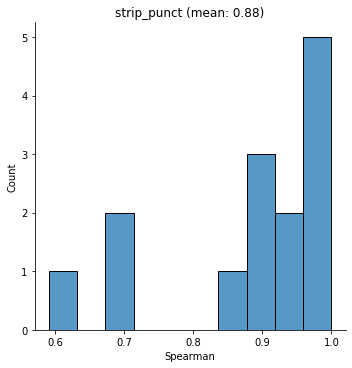

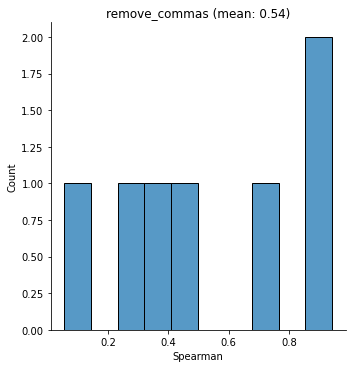

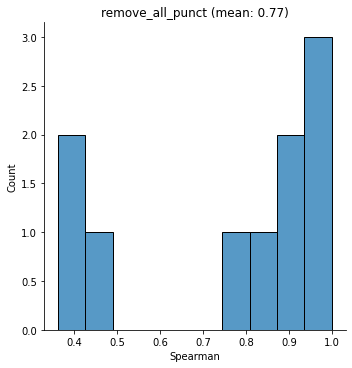

In [117]:
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values']).correlation, axis=1)
    sns.displot(df['spearman'], bins=10)
    plt.title(f"{perturbation} (mean: {np.round(np.mean(df['spearman']), 2)})")
    plt.xlabel('Spearman')
    plt.show()

In [100]:
print(df.loc[19]['sentence'])
print(bert_detokenize(df.loc[19]['strip_punct_tokens']))
print(df.loc[19]['strip_punct_concat'])

Another one of those estrogen overdose movies like `` Divine Secrets of the Ya Ya Sisterhood , '' except that the writing , acting and character development are a lot better .
another one of those estrogen overdose movies like `` divine secrets of the ya ya sisterhood , '' except that the writing , acting and character development are a lot better 
another one of those estrogen overdose movies like ` ` divine secrets of the ya ya sisterhood , ' ' except that the writing , acting and character development are a lot better 


"another one of those estrogen overdose movies like `` divine secrets of the ya ya sisterhood , ' ' except that the writing , acting and character development are a lot better "

In [88]:
pd.DataFrame(
    {
        'orig_tokens': df.loc[2]['shap_orig_tokens'],
        'orig_values': df.loc[2]['shap_orig_values']
    }
).sort_values('orig_values', ascending=False).head(10)

,orig_tokens,orig_values
3,absorbing,0.035836
4,film,0.035836
5,that,0.035836
6,manages,0.035836
7,to,0.035836
8,convey,0.035836
9,more,0.035836
10,substance,0.035836
15,and,0.019798
14,##s,0.019798


In [89]:
pd.DataFrame(
    {
        'orig_tokens': df.loc[2]['shap_strip_punct_tokens'],
        'orig_values': df.loc[2]['shap_strip_punct_values']
    }
).sort_values('orig_values', ascending=False).head(10)

,orig_tokens,orig_values
3,absorbing,0.034524
4,film,0.034524
5,that,0.034524
6,manages,0.034524
7,to,0.034524
8,convey,0.034524
9,more,0.034524
10,substance,0.034524
15,and,0.020096
14,##s,0.020096


Olivier/David code:

In [52]:
# to count the number of times every perturbation leads to a significant change in interpretation
count = {}
for perturbation in perturbation_list:
    count[perturbation] = 0

for r in [5]:
#for r in range(rows_to_review):
    sentence = {}
    tokens = {}
    success = {}
    pert_indices = {}
    scores = {}
    prediction = {}
    comparison = {}

    sentence['orig'] = df.iloc[r, orig_col_index]
    tokens['orig'] = df.iloc[r,tokens_col_index]
    scores['orig'] = np.array(explainer.explain_instance(sentence['orig'])[0])
    prediction['orig'] = explainer.explain_instance(sentence['orig'])[1]
    
    # creating dict for easier reference
    for perturbation in perturbation_list:
        col_index = df.columns.get_loc(perturbation + '_concat')
        sentence[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_tokens')
        tokens[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_success')
        success[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_pert_ind')
        pert_indices[perturbation] = df.iloc[r, col_index]
        if success[perturbation] != 0:
            scores[perturbation] = np.array(explainer.explain_instance(sentence[perturbation])[0])
            prediction[perturbation] = explainer.explain_instance(sentence[perturbation])[1]
        
    for perturbation in perturbation_list:
        # interpretations should only be compared if a sentence has been modified
        if success[perturbation] == 0:
            comparison[perturbation] = None
            continue
        # interpretations should not be compared if prediction has changed
        elif prediction[perturbation] != prediction['orig']:
            comparison[perturbation] = None
            continue
        else:
            # variable to track whether an important token has been changed 
            change_flag = 0
            for i in pert_indices[perturbation]:
            # if gradient greater than 0.05, token can be considered as important
                if scores['orig'][i] > 0.05:
                    change_flag += 1
            # interpretations should not be compared if an important token has been changed
            if change_flag > 0:   
                comparison[perturbation] = None
                continue
            else:
                
                if perturbation in perturbation_reduction: # perturbation category 1
                    # remove empty tokens from tokenised version of perturbed sentence
                    tokens[perturbation] = [tokens[perturbation][i] for i in range(len(tokens[perturbation])) 
                               if not i in pert_indices[perturbation]]
                    # remove scores of tokens that have been deleted as a result of the perturbation
                    orig_score_reduced = np.array([scores['orig'][i] for i in range(len(scores['orig'])) 
                                   if not i in pert_indices[perturbation]])
                    # normalise gradient
                    orig_score_reduced = orig_score_reduced/np.sum(orig_score_reduced)
                    orig_score_for_comparison = orig_score_reduced
                elif perturbation == 'swap_adj': # perturbation category 2
                    orig_score_swapped = deepcopy(scores['orig'])
                    for i in range(len(pert_indices[perturbation][::2])):
                        index_adj_1 = pert_indices[perturbation][i]
                        index_adj_2 = pert_indices[perturbation][i+1]
                        score_adj_1 = scores['orig'][index_adj_1]
                        score_adj_2 = scores['orig'][index_adj_2]
                        orig_score_swapped[index_adj_1] = score_adj_2
                        orig_score_swapped[index_adj_2] = score_adj_1
                    orig_score_for_comparison = orig_score_swapped
                else: # remaining perturbations
                    orig_score_for_comparison = scores['orig']
                
                if len(orig_score_for_comparison) != len(scores[perturbation]):
                    print('length not matching after perturbation')
                    comparison[perturbation] = None
                else:
                    comparison[perturbation] = spearmanr(orig_score_for_comparison, scores[perturbation])[0]
                    
                    #print(tokens['orig'])
                    #print(tokens[perturbation])
                    #print(['{:.3f}'.format(x) for x in scores['orig']])
                    #print(['{:.3f}'.format(x) for x in scores[perturbation]])
                    
                    if comparison[perturbation] < 0.8:
                        
                        count[perturbation] += 1
                        visualise_weights(tokens['orig'], scores['orig'])
                        visualise_weights(tokens[perturbation], scores[perturbation])

                        
    for p in range(len(perturbation_list)):
        perturbation = perturbation_list[p]
        results_matrix[r,p] = comparison[perturbation]

TypeError: 'NoneType' object is not subscriptable